# Remote Sensing Time Series for Seeding Units

In [1]:
# Import libraries
import os
import datetime
from datetime import date
import configparser

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

# Import custom module
from vegrestoretools import FisToDataframe, EvalScripts

from sentinelhub import SHConfig, FisRequest, BBox, Geometry, CRS, WcsRequest, CustomUrlParam, \
    DataCollection, HistogramType
from sentinelhub.time_utils import iso_to_datetime, parse_time

In [2]:
# Read configuration file
config_ini = configparser.ConfigParser()
config_ini.read('sentinel2_setup.ini')

# SentinelHub configuration
config = SHConfig()
config.instance_id = config_ini['Config']['instance_id'] # Instance ID for the Configuration
config.sh_client_id = config_ini['Config']['sh_client_id'] # Credentials from the OAuth client
config.sh_client_secret = config_ini['Config']['sh_client_secret']
config.save()

In [3]:
# Other parameters
startDate = '2017-01-01'

In [4]:
# Set working directory
os.chdir(os.path.join('D:/',
                      'McKinley'))

## Import and process seeding unit polygons

In [5]:
# Import seeding units shapefile
mckinley_seeding_path = os.path.join(
    'vectors', 'Golder_GIS_Data_Export_2021_04_27_Seeding', 'Seeding_Master_shifted.shp')
mckinley_seeding = gpd.read_file(mckinley_seeding_path)

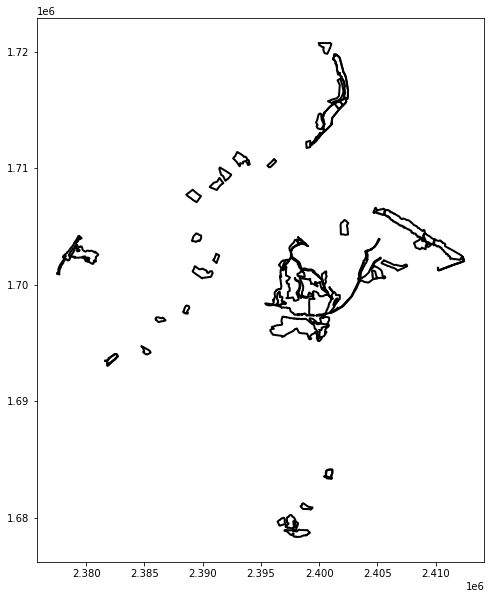

In [6]:
# Clean up columns
mckinley_seeding_subset = mckinley_seeding.loc[:, [
    'Mine_Area', 'Start_Year', 'End_Year', 'GIS_Acre2', 'Agreement', 'Seed_Type', 'TYPE', 'geometry']]

# Remove rows older than 2013
drop = mckinley_seeding_subset[mckinley_seeding_subset['Start_Year'] < 2013].index
mckinley_seeding_subset.drop(drop, inplace=True)

# Filter polygons to remove roads, tracks, ROW's
# Calculate perimeter-area ratio
mckinley_seeding_subset['PAR'] = mckinley_seeding_subset.geometry.length / \
    mckinley_seeding_subset.geometry.area

# Filter by perimeter-area ratio
threshold = 0.01
mckinley_seeding_subset_PARlo = mckinley_seeding_subset[mckinley_seeding_subset['PAR'] < threshold]

# Plot the filtered seeding units
fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
mckinley_seeding_subset_PARlo.plot(ax=ax,
                                        color='None',
                                        edgecolor='black',
                                        linewidth=2)

In [7]:
mckinley_seeding_subset_PARlo

,Mine_Area,Start_Year,End_Year,GIS_Acre2,Agreement,Seed_Type,TYPE,geometry,PAR
172,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
816,None,2013,2013,55.702517,Permanent Program,Seed,Seeding,"POLYGON ((2378986.229 1702322.589, 2378982.791...",0.008140
913,None,2013,2013,45.834100,Permanent Program,Seed,Seeding,"MULTIPOLYGON (((2403966.161 1702249.371, 24039...",0.008526
916,None,2013,2013,166.414201,Permanent Program,Seed,Seeding,"POLYGON ((2398388.920 1703880.919, 2398403.538...",0.009537
1265,10,2013,2013,5.505459,Permanent Program,Reseed,Reseeding,"POLYGON ((2385163.827 1693999.402, 2385155.351...",0.009982
1314,11,2013,2013,96.634051,Permanent Program,Seed,Seeding,"POLYGON ((2399754.113 1695408.235, 2399762.904...",0.003032
1319,11,2013,2013,11.045688,Permanent Program,Seed,Seeding,"POLYGON ((2399974.214 1696112.931, 2399974.230...",0.009493
1558,None,2014,2014,83.281620,Permanent Program,Reseed,Reseeding,"POLYGON ((2402224.363 1715573.020, 2402213.169...",0.005979
1588,None,2014,2014,7.462737,Permanent Program,Reseed,Reseeding,"POLYGON ((2404782.569 1706591.781, 2404802.102...",0.009511
1589,None,2014,2014,10.456143,Permanent Program,Reseed,Reseeding,"POLYGON ((2409735.763 1703942.635, 2409767.743...",0.007148


## Run the SentinelHub query

In [8]:
seeding_aois = mckinley_seeding_subset_PARlo

# Convert seeding polygons to WGS84
seeding_aois = seeding_aois.to_crs("EPSG:4326")

# Explode multipolygons to polygons to query with FIS request
seeding_aois_exploded = seeding_aois.explode()

# Create empty list to store results for all VMU's
output_list = []

# Loop over VMU's
for index, row in seeding_aois_exploded.iterrows():
    
    # Process specific seeding units
    if (index[0] == 172 or index[0] == 2650):

        # Status message
        print('Now processing Seeding Unit Index: ' + str(index[0]))

        # Setup parameters for FIS request
        geometry_list = Geometry(row.geometry, CRS.WGS84)
        time_interval = (startDate, date.today())
        
        # Custom script to pass to SentinelHub
        evalscript = EvalScripts('Sentinel_2_NDVI')
        
        # Build FIS request
        fis_request = FisRequest(
            data_collection=DataCollection.SENTINEL2_L2A,
            layer='BANDS-S2-L2A',
            geometry_list=[geometry_list],
            time=time_interval,
            resolution='100m',
            custom_url_params={CustomUrlParam.EVALSCRIPT: evalscript},
            config=config
        )

        # Run the FIS request
        fis_data = fis_request.get_data()

        # Convert the FIS result to a dataframe
        fis_df = FisToDataframe(fis_data)

        # Add the seeding unit ID to the dataframe
        fis_df['ID'] = index[0]

        # Append the df to the temporary list
        output_list.append(fis_df)

    else:
        # Status message
        print('skipping this Seeding Unit')

# Concatenate the VMU results into a single DF
fis_df_all_raw = pd.concat(output_list, axis=0)
fis_df_all_raw

Now processing Seeding Unit Index: 172
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Seeding Unit
skipping this Se

,date,min,max,mean,stDev,clm_mean,snw_mean,ID
0,2021-05-24,0.093460,0.145264,0.110174,0.020601,0.0,0.000000,172
1,2021-05-21,-0.009225,0.016267,0.004830,0.009395,1.0,0.250000,172
2,2021-05-19,-0.052029,0.049698,-0.007195,0.043277,1.0,0.000000,172
3,2021-05-16,0.086651,0.132009,0.102319,0.018241,0.0,0.000000,172
4,2021-05-14,0.088745,0.141143,0.106937,0.020434,0.0,0.000000,172
...,...,...,...,...,...,...,...,...
533,2017-02-21,0.097730,0.149043,0.116268,0.010677,0.0,0.000000,2650
534,2017-02-14,-0.015393,0.025167,0.001644,0.007732,1.0,0.000000,2650
535,2017-02-04,-0.076547,0.513308,0.031470,0.118355,0.0,36.900000,2650
536,2017-02-01,-0.057969,0.070926,-0.026381,0.030557,0.0,83.100000,2650


## Clean up the FIS results

In [9]:
fis_df_all = fis_df_all_raw.copy(deep=True)

# Convert stats values from objects to float
fis_df_all['min'] = fis_df_all['min'].astype(float, errors = 'raise')
fis_df_all['max'] = fis_df_all['max'].astype(float, errors = 'raise')
fis_df_all['mean'] = fis_df_all['mean'].astype(float, errors = 'raise')
fis_df_all['stDev'] = fis_df_all['stDev'].astype(float, errors = 'raise')
fis_df_all['clm_mean'] = fis_df_all['clm_mean'].astype(float, errors = 'raise')
fis_df_all['snw_mean'] = fis_df_all['snw_mean'].astype(float, errors = 'raise')

# Drop rows with NaN
fis_df_all.dropna(inplace=True)

# Remove cloudy results
fis_df_all.drop(fis_df_all[fis_df_all['clm_mean'] > 0].index, inplace = True)

# Format the date field
fis_df_all['date'] = pd.to_datetime(fis_df_all['date'])

# Average over multipolygon VMU's
fis_df_all = fis_df_all.groupby(['date', 'ID']).mean()

# Sort by date
fis_df_all.sort_values(['ID','date'], inplace=True)

# Reset index
fis_df_all.reset_index(inplace=True)
fis_df_all.set_index('date', inplace=True)

fis_df_all

,ID,min,max,mean,stDev,clm_mean,snw_mean
date,,,,,,,
2017-02-01,172,0.036819,0.093517,0.059852,0.020871,0.0,5.75
2017-02-04,172,0.083744,0.161788,0.113142,0.031281,0.0,0.00
2017-02-21,172,0.105520,0.180918,0.127385,0.031246,0.0,0.00
2017-03-06,172,0.120918,0.212329,0.148161,0.037443,0.0,0.00
2017-03-13,172,0.088841,0.165789,0.112921,0.030896,0.0,0.00
...,...,...,...,...,...,...,...
2021-05-06,2650,0.089775,0.142289,0.120899,0.011900,0.0,0.00
2021-05-11,2650,0.087706,0.139262,0.117857,0.012438,0.0,0.00
2021-05-14,2650,0.101309,0.155668,0.132854,0.013285,0.0,0.00


## Plot the results

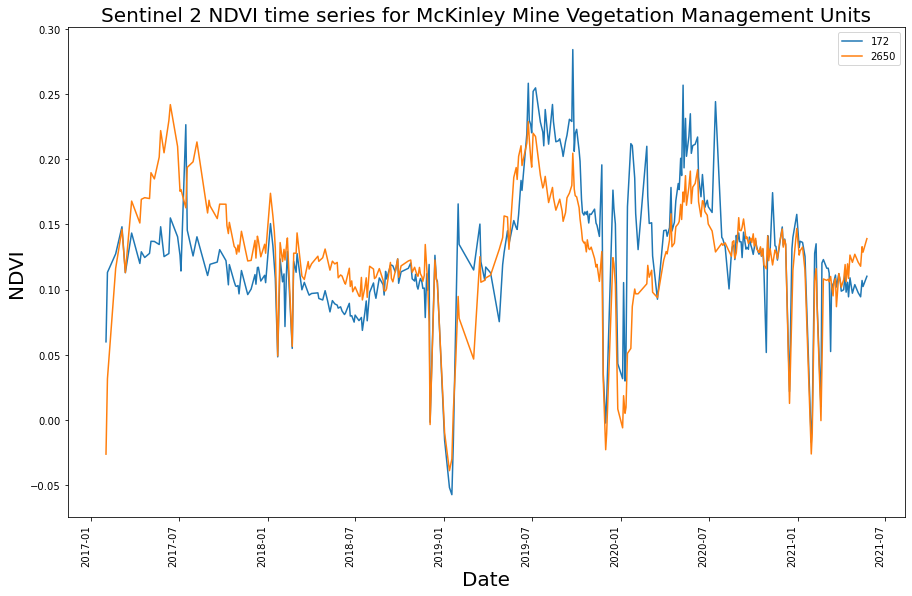

In [10]:
# Setup plot
fig, ax = plt.subplots(figsize=(15, 10))

# Build list of unique sites for legend
sites = fis_df_all.ID.unique()

fis_df_all.reset_index().groupby('ID').plot(x='date', y='mean', ax=ax)

# Legend and labels
plt.legend(sites)

plt.xlabel("Date", fontsize=20)
plt.ylabel("NDVI", fontsize=20)

ax.set_title(
    "Sentinel 2 NDVI time series for McKinley Mine Vegetation Management Units", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()